In [ ]:
import json
from math import sqrt, pi, sin, degrees, cos, radians

import cadquery as cq 
from jupyter_cadquery import set_defaults, set_sidecar, get_defaults, reset_cache, Animation
from jupyter_cadquery.cadquery import show, PartGroup, Part, Faces, Edges
from jupyter_cadquery.mate_assembly import Mate, MAssembly
 

# remove "clean" to avoid errors OCP kernel error
cq.occ_impl.shapes.Shape.clean = lambda x: x

#set_sidecar("balls")
# tools shows the tree in the left side of the preview window, 
# useful on a large screen, but bad on the ipad
set_defaults(
    #tree_width=100,
    #cad_width=400,
    #display="sidecar",
    axes=True, 
    axes0=True, 
    #edge_accuracy=0.01, 
    #mate_scale=1, 
    #zoom=1, 
    #bb_factor=.5, 
    tools=True,
    #mac_scrollbar=False,
)

pingpong_ball_diameter = 38 #mm
led_diameter = 8 #mm
led_base_diameter = 12 #mm

pingpong_ball_radius = pingpong_ball_diameter / 2



In [ ]:

def generate_spherepoints():
    # this had to be run on the desktop directly because I couldn't get wolframengine working in dockerized juypter
    from wolframclient.evaluation import WolframLanguageSession
    from wolframclient.language import wl

    session = WolframLanguageSession()

    for n in range(101):
        sp = session.evaluate(wl.SpherePoints(n))
        with open(f"sp/{n}.json", "w") as f:
            json.dump([(x,y,z) for (x,y,z) in sp], f)


def load_spherepoints(n):
    with open(f"sp/{n}.json", "r") as f:
        return json.load(f)
  



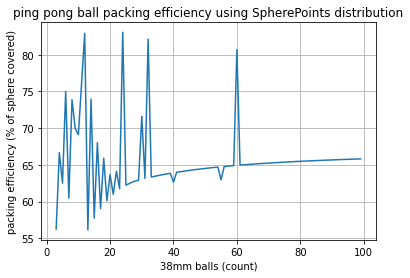

top 4 packing efficiencies
ball count 24: e=83.1%, d=64.1mm
ball count 12: e=82.9%, d=34.3mm
ball count 32: e=82.1%, d=80.6mm
ball count 60: e=80.7%, d=125.8mm


In [82]:

def min_sphere_radius(sp, r):
    
    # determine which two points in the spherepoints are closest together (sp1 and sp2)
    
    closest_a = None
    closest_b = None
    # this is a unitsphere, so 2 is the biggest possible distance
    closest_distance = 2
    
    remaining = sp.copy()
    
    while remaining:
        i = remaining.pop()
        
        for x in remaining:
            
            # get the distance between i and x
            dist = distance_finder(i, x)
            if dist <= closest_distance:
                closest_distance = dist
                closest_a = i
                closest_b = x
        
    # calculate the scalar to make the distance between spA and spB = r * 2
    scalar = (r * 2.0) / closest_distance
    
    # return the distance from spA to 0,0,0 * the calculated scalar (- r maybe)
    sphere_radius = distance_finder(closest_a, (0, 0, 0)) * scalar
    sphere_radius -= r
    return sphere_radius

    
def distance_finder(one, two):
    x1, y1, z1 = one  # first coordinates
    x2, y2, z2 = two  # second coordinates

    return (((x2-x1)**2)+((y2-y1)**2)+((z2-z1)**2))**(1/2)    
    

def efficiency(globe_diameter, N, r):
    
    # calculate the surface area of the globe
    globe_surface_area = 4 * pi * ((globe_diameter/2) + r)**2
    
    # calculate the area of the circle of the pingping ball at the equator (FIXME: the equator is wrong)
    pingpong_ball_area_at_equator = pi * r**2
    
    # determine given N, what % of the globe will be covered in balls
    pct_covered_by_balls = (pingpong_ball_area_at_equator * N) / globe_surface_area
    
    return pct_covered_by_balls * 100


def plot_eff(eff):
    import matplotlib
    import matplotlib.pyplot as plt
    import numpy as np

    n, e, _ = list(zip(*eff))
    
    fig, ax = plt.subplots()
    ax.plot(n, e)

    ax.set(
        xlabel='38mm balls (count)', 
        ylabel='packing efficiency (% of sphere covered)',
        title='ping pong ball packing efficiency using SpherePoints distribution'
    )
    ax.grid()

    fig.savefig("spherepoints_packing_efficiency.png")
    plt.show()




eff = []


# test all the combinations of ball counts from 3 to 100
for n in range(3, 100):
    
    # load the wolfram spherepoints on a unitsphere
    sp = load_spherepoints(n)
    
    # determine the smallest inner diameter d for the given sp at r where no balls interfere with eachother
    d = min_sphere_radius(sp, r=pingpong_ball_radius) * 2
    
    # calculate the efficiency of the solution and log the results
    e = efficiency(globe_diameter=d, N=n, r=pingpong_ball_radius)
    #print(f"{n} spheres e:{e:.02f} d:{d:.02f}")
    
    eff.append((n, e, d))


plot_eff(eff)


x = 4
from operator import itemgetter
top_x = sorted(eff, key=itemgetter(1), reverse=True)[:x]

print(f"top {x} packing efficiencies")
for n, e, d in top_x:
    print(f"ball count {n}: e={e:.01f}%, d={d:.01f}mm")


In [77]:

def visualize_sp(globe_diameter, n, r):

    xyz_points = load_spherepoints(n)

    offset = (globe_diameter/2) + r

    globe = cq.Workplane("XY").sphere((globe_diameter/2))
    
    L = lambda *args: cq.Location(cq.Vector(*args))
    C = lambda *args: cq.Color(*args)
    
    a = MAssembly(globe, name="globe", color=C("gray"), loc=L(0, 0, 0))
    
    for coord in xyz_points:
        ball = cq.Workplane("XY").sphere(r)
        a.add(ball, name=f"ball", color=C("MediumAquaMarine"), loc=L((coord[0]*offset, coord[1]*offset, coord[2]*offset)))
    
    w = show(a)
    
    from ipywidgets.embed import embed_data


    data = embed_data(views=[w.cq_view.renderer])

    
    msg = f"Visualization of {n} {r*2}mm diameter pingping balls on a {globe_diameter:.02f}mm diameter sphere"
    print(msg)

    html_template = """
    <html>
      <head>

        <title>{msg}</title>

        <!-- Load RequireJS, used by the IPywidgets for dependency management -->
        <script 
          src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" 
          integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" 
          crossorigin="anonymous">
        </script>

        <!-- Load IPywidgets bundle for embedding. -->
        <script
          data-jupyter-widgets-cdn="https://cdn.jsdelivr.net/npm/"
          src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" 
          crossorigin="anonymous">
        </script>

        <!-- The state of all the widget models on the page -->
        <script type="application/vnd.jupyter.widget-state+json">
          {manager_state}
        </script>
      </head>

      <body>

        <h1>{msg}</h1>

        <div id="first-slider-widget">
          <!-- This script tag will be replaced by the view's DOM tree -->
          <script type="application/vnd.jupyter.widget-view+json">
            {widget_views[0]}
          </script>
        </div>

      </body>
    </html>
    """

    manager_state = json.dumps(data['manager_state'])
    widget_views = [json.dumps(view) for view in data['view_specs']]
    rendered_template = html_template.format(manager_state=manager_state, widget_views=widget_views, msg=msg)
    with open(f'docs/export_{n}.html', 'w') as fp:
        fp.write(rendered_template)

    

In [78]:
x = 0
n, e, d = top_x[x]
print(f"(#{x+1} most efficient solution under 100 balls)") 
visualize_sp(
    globe_diameter=d, 
    n=n, 
    r=r
)

(#1 most efficient solution under 100 balls)


Visualization of 24 38.0mm diameter pingping balls on a 64.12mm diameter sphere


In [79]:
x = 1
n, e, d = top_x[x]
print(f"(#{x+1} most efficient solution under 100 balls)")
visualize_sp(
    globe_diameter=d, 
    n=n, 
    r=r
)

(#2 most efficient solution under 100 balls)


Visualization of 12 38.0mm diameter pingping balls on a 34.28mm diameter sphere


In [80]:
x = 2
n, e, d = top_x[x]
print(f"(#{x+1} most efficient solution under 100 balls)")
visualize_sp(
    globe_diameter=d, 
    n=n, 
    r=r
)

(#3 most efficient solution under 100 balls)


Visualization of 32 38.0mm diameter pingping balls on a 80.59mm diameter sphere


In [81]:
x = 3
n, e, d = top_x[x]
print(f"(#{x+1} most efficient solution under 100 balls)")
visualize_sp(
    globe_diameter=d, 
    n=n, 
    r=r
)

(#4 most efficient solution under 100 balls)


Visualization of 60 38.0mm diameter pingping balls on a 125.84mm diameter sphere
